# Проект - 3. Задача классификации 

*   Бизнес-задача: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

*   Техническая задача для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.




In [2]:
#!pip install Optuna

In [3]:
# импортируем необходимые библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.neighbors import LocalOutlierFactor

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

 Прочитаем наши данные, выведем информацию о столбцах, и их содержании.

In [4]:
df = pd.read_csv('bank_fin.csv', sep = ';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


---
как мы видим у нас 17 столбцов и 11162 строки, 6 числовых, 11 текстовых

In [5]:
# Проверим наши данные на наличие пропусков
df.isna().sum()


age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

---
В столбце баланса имеются пропуски значений


### Пропуски в данных

Для начала преобразуем признак 'balance' из текстового(object) в числовой(float) убрав знак $

In [6]:
df['balance'] = df['balance'].apply(lambda x: float(x.replace(' ','').replace(',','.')[:-1]) if x is not np.nan else x)
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

In [7]:
# Заполним пропуски в столбце медианным значением
df['balance'] = df['balance'].fillna(df['balance'].median())

### Неявные пропуски данных

In [8]:
# У признаков education и job имеются неявные пропуски значений и обозначены как 'unknown'
df['job'].value_counts(), df['education'].value_counts()

(management       2566
 blue-collar      1944
 technician       1823
 admin.           1334
 services          923
 retired           778
 self-employed     405
 student           360
 unemployed        357
 entrepreneur      328
 housemaid         274
 unknown            70
 Name: job, dtype: int64,
 secondary    5476
 tertiary     3689
 primary      1500
 unknown       497
 Name: education, dtype: int64)

---
Уберем пропуски заменив их модальными значениями

In [9]:
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x == 'unknown' else x)

### Выбросы

Для удаления выбросов применим алгоритм LocalOutlierFactor, который принимает решение о признания объекта выбросом на основе его ближайших соседей

In [10]:
x = df.copy()
# для начала преобразуем текстовые признаки в числовые

# создадим список из порядковых признаков и применим к ним LabelEncoder
columns_for_transform = ['education','default','housing','loan','deposit'] 
le = LabelEncoder()
for feature in columns_for_transform:
  x[feature] = le.fit_transform(x[feature])

# остальные закодируем Onehot кодированием
x = pd.get_dummies(x)

#Обучим наш алгоритм и обнаружим наши пропуски
lof = LocalOutlierFactor()
out_pred = lof.fit_predict(x)

# Отфильтруем наши данные и удалим выбросы 
mask = out_pred != -1
df = df[mask]

## Часть 2:  Разведывательный анализ

### Сбалансированность классов

Клиентов не открывших депозит: 5774
Клиентов открывших депозит: 5119
---------------------------------------------


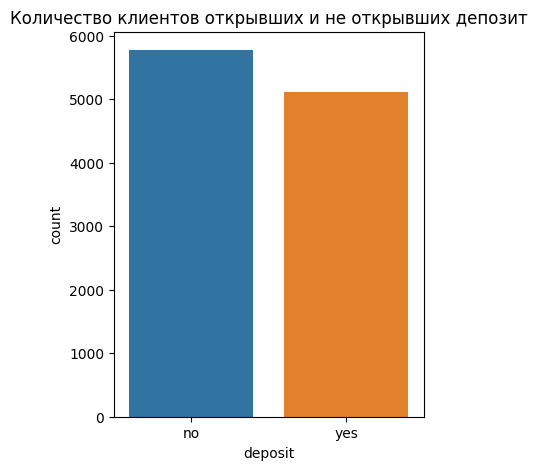

In [11]:
# изучим соотношение классов нашей целевой переменной на предмет несбалансированности
print('Клиентов не открывших депозит: {}'.format(df['deposit'].value_counts()[0]))
print('Клиентов открывших депозит: {}'.format(df['deposit'].value_counts()[1]))
print('---------------------------------------------')
plt.figure(figsize=(4,5))
fig = sns.countplot(x=np.where(df['deposit']=='yes',1,0))
fig.set_title('Количество клиентов открывших и не открывших депозит');
fig.set_xlabel('deposit')
fig.set_xticklabels(['no','yes']);




---
Как мы видим среди данных есть незначительный перевес клиентов неоткрывших депозит в банке, который необходимо учесть в дальнейшем


### Описательные статистики для количественных переменных

In [12]:
# Взглянем на количественные переменные в данных 
# и определим меры центральной тенденции, минимумы/максимумы значений
columns_for_visual = df.select_dtypes(exclude='object').columns
df[columns_for_visual].describe().T

,count,mean,std,min,25%,50%,75%,max
age,10893.0,41.181034,11.844874,18.0,32.0,39.0,49.0,95.0
balance,10893.0,1480.025429,2690.882998,-1206.0,130.0,556.0,1704.0,32685.0
day,10893.0,15.660149,8.419118,1.0,8.0,15.0,22.0,31.0
duration,10893.0,363.183604,325.712982,2.0,138.0,252.0,485.0,2330.0
campaign,10893.0,2.504177,2.668849,1.0,1.0,2.0,3.0,63.0
pdays,10893.0,48.495915,102.360461,-1.0,-1.0,-1.0,-1.0,774.0
previous,10893.0,0.802075,2.188955,0.0,0.0,0.0,0.0,58.0




---
Как мы видим возраст клиентов банка варьируется от 18 до 95 лет, средний возраст около 40 лет.
Баланс счета от отрицательного до 32 тыс. долларов, средний баланс по счетам составляет около 2500 тысяч.


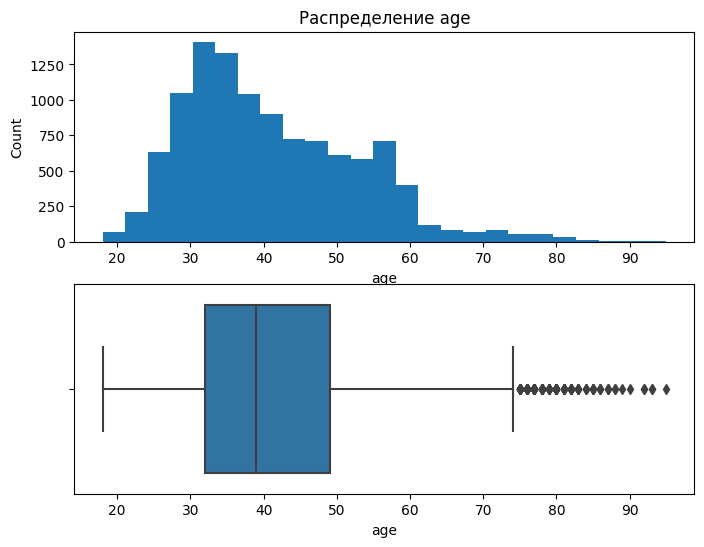

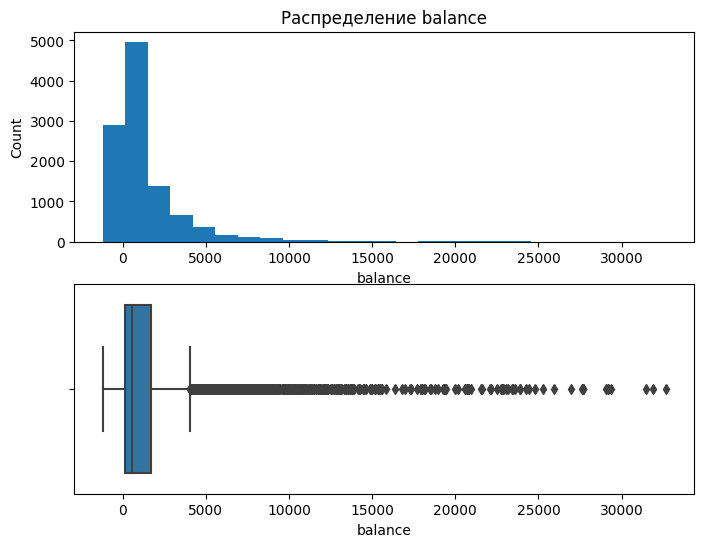

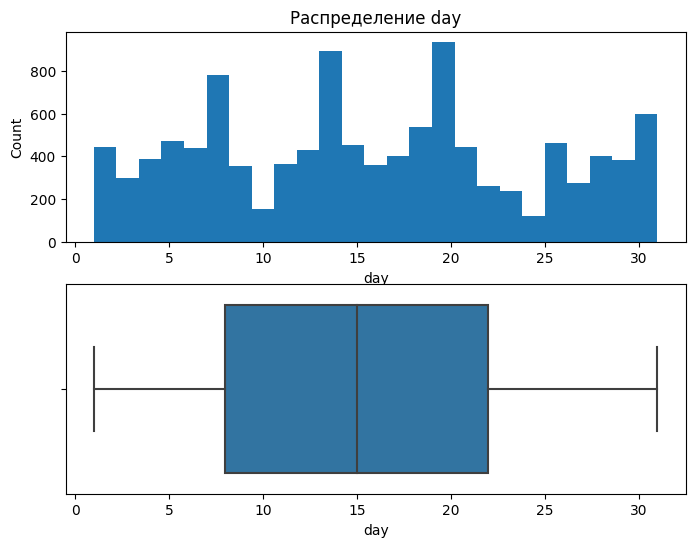

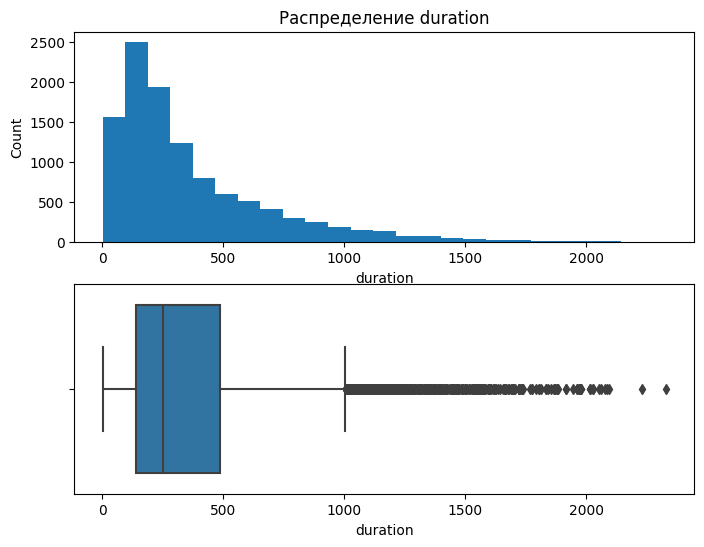

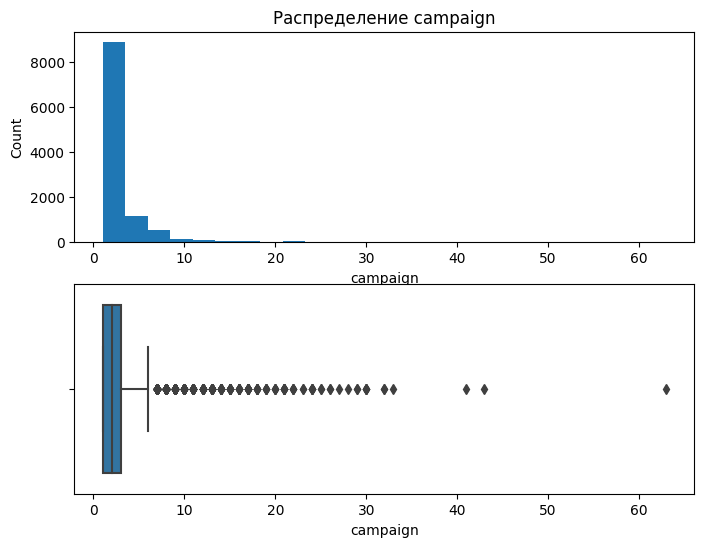

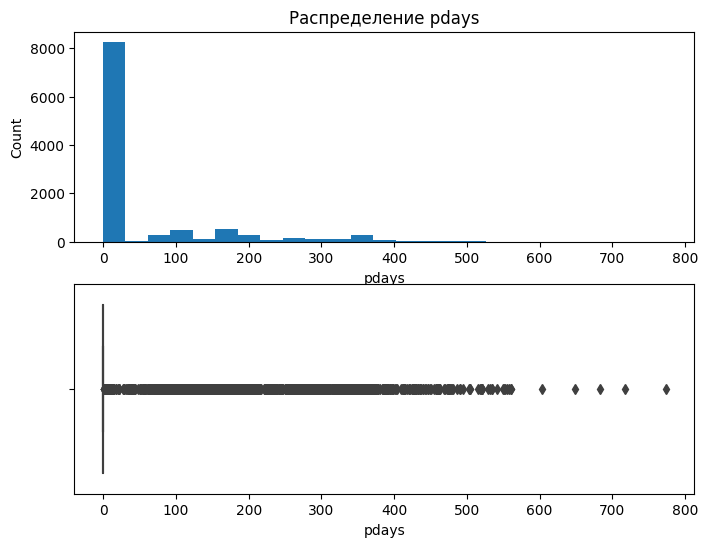

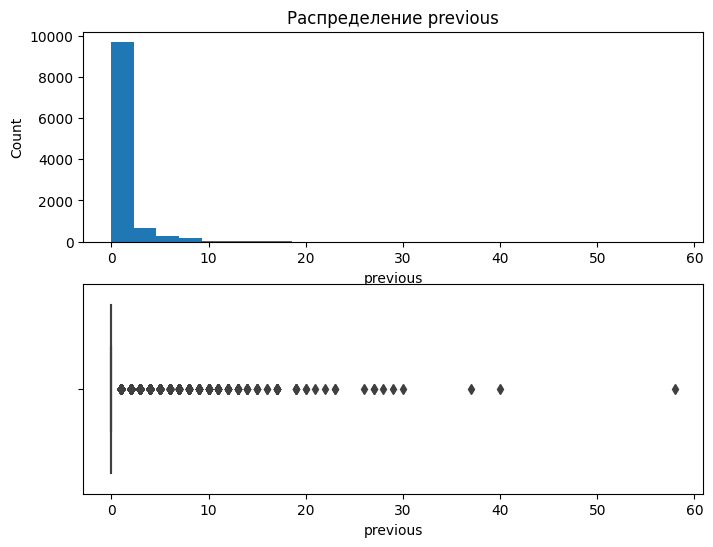

In [13]:
# Визуализируем наши данные построим их распределение и межквартильный размах 
for n in columns_for_visual:
  fig,axes = plt.subplots(2,1,figsize=(8,6))
  axes[0].hist(df[n],bins=25)
  axes[0].set_xlabel(n)
  axes[0].set_ylabel('Count')
  axes[0].set_title(f'Распределение {n}')
  sns.boxplot(x=df[n],ax=axes[1])
fig.show()

### Описательные статистики для категориальных переменных

In [14]:
# Рассмотрим категориальные переменные в данных
categorial_columns = df.select_dtypes(include='object').columns
df[categorial_columns].describe().T

,count,unique,top,freq
job,10893,11,management,2569
marital,10893,3,married,6196
education,10893,3,secondary,5837
default,10893,2,no,10732
housing,10893,2,no,5763
loan,10893,2,no,9486
contact,10893,3,cellular,7842
month,10893,12,may,2759
poutcome,10893,4,unknown,8214
deposit,10893,2,no,5774




---
Из данных следует:
*   Среди клиентов четверть работают в сфере менеджмента
*   больше половины женаты/замужем
*   половина клиентов имеет среднее образование
*   почти все клиенты не имеют просроченый кредит
*   около половины клиентов имеют кредит на жилье
*   почти никто не имеет кредит на наличные нужды
*   большиство было привлечено посредством телефонного разговора




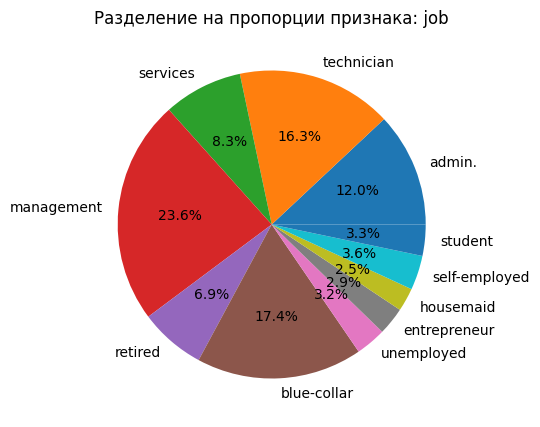

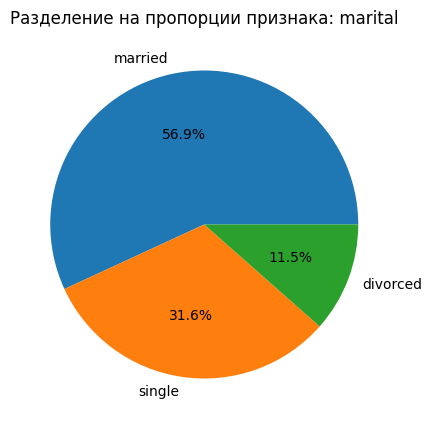

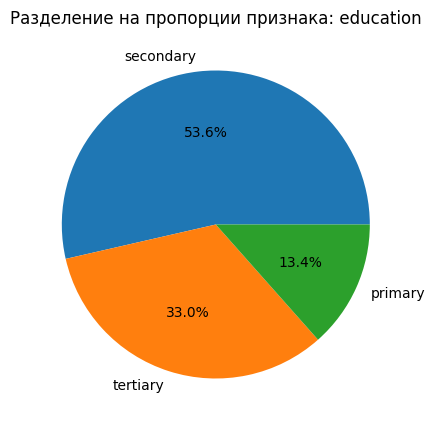

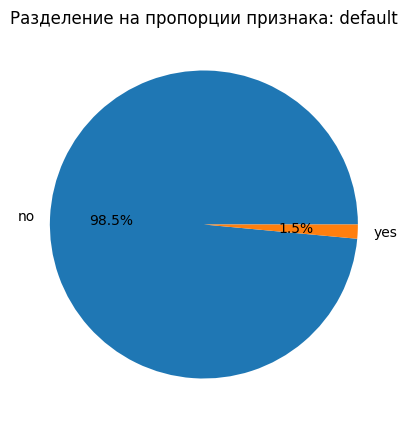

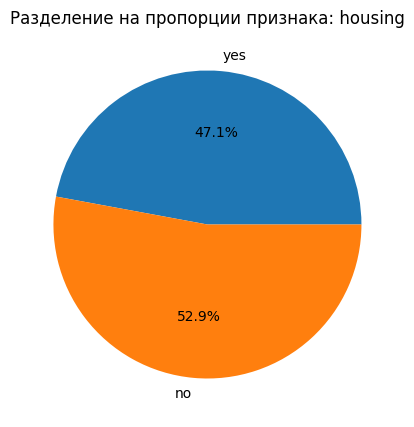

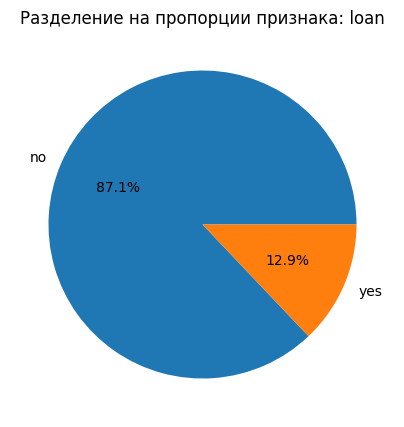

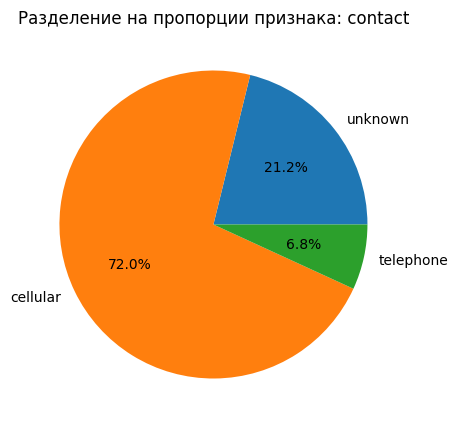

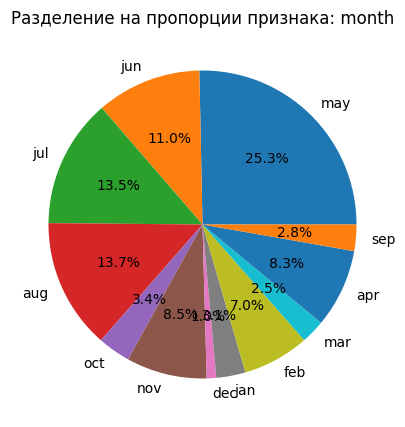

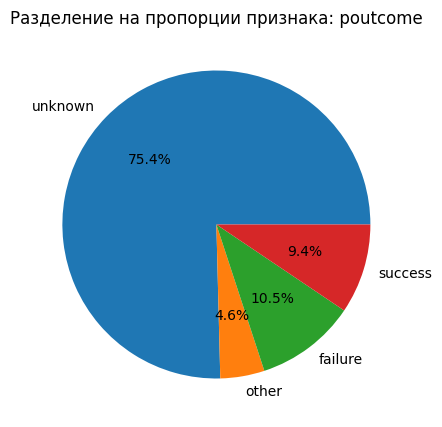

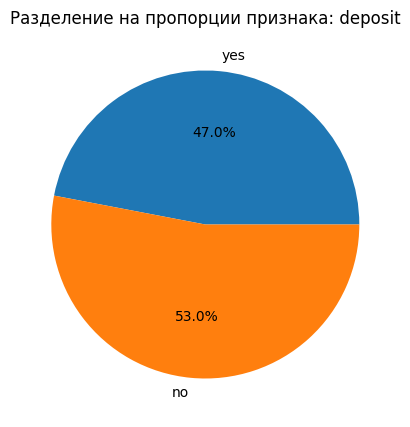

In [15]:
# Визуализируем данные 
for n in categorial_columns:
  fig,axes = plt.subplots(figsize=(5,5))
  plt.pie(x=df[n].value_counts(sort=False),labels=df[n].unique(),autopct='%.1f%%')
  axes.set_title(f'Разделение на пропорции признака: {n}')
  fig.show()

Посмотрим как влияет участие в предыдущей маркетинговой компании на решение в текущей. Построим стобчатые диаграммы:

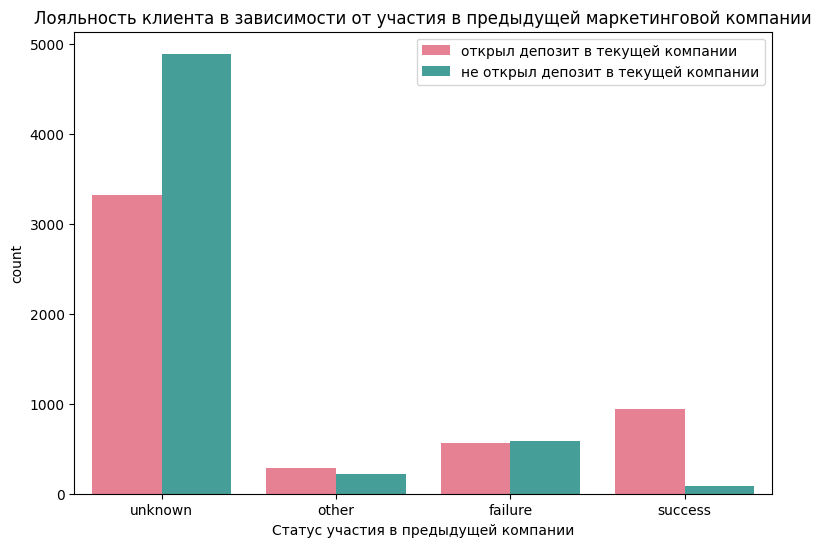

In [16]:
plt.figure(figsize=(9,6))
fig = sns.countplot(x=df['poutcome'],hue=df['deposit'],palette='husl')
fig.set_title('Лояльность клиента в зависимости от участия в предыдущей маркетинговой компании')
fig.set_xlabel('Статус участия в предыдущей компании');
fig.legend(labels=['открыл депозит в текущей компании','не открыл депозит в текущей компании']);




---
Как мы видим большинство клиентов, которые поучавствовали в предыдущей маркетинговой компании открыли депозит в текущей компании

In [17]:
# узнаем в каком месяце процент отказов от предложения был наибольшим

percentage_of_failures = dict()

for month in df['month'].unique():
# вычислим общее количество клиентов
  count_of_failures = df[(df['month']==month) & (df['deposit']=='no')]['month'].count()
# и клиентов отказавшихся от открытия депозита
  count_of_month = df[df['month']==month]['month'].count()
# посчитаем процент по каждому месяцу и добавим значения в словарь
  percent_of_fail_per_month = (count_of_failures / count_of_month) * 100
  percentage_of_failures[month] = round(percent_of_fail_per_month, 2)

print('Процент отказов от предложения по месяцам:')
print(sorted(percentage_of_failures.items(),key=lambda x: x[1],reverse=True))

Процент отказов от предложения по месяцам:
[('may', 67.71), ('jan', 59.46), ('jul', 59.1), ('nov', 57.65), ('jun', 56.0), ('aug', 55.0), ('feb', 43.36), ('apr', 37.82), ('oct', 16.58), ('sep', 14.9), ('mar', 10.29), ('dec', 9.17)]




---
Как мы видим май и январь и июль лидируют по отказам в процентном соотношении, возможно это связано с периодом отпусков


In [18]:
# посмотрим какие возрастные группы более склонны открывать депозит в банке

age = dict()
# создадим маски с возрастными группами (до 30, 30-40, 40-50, 50-60 и 60+ лет)
mask_less_30 = df['age']<30
mask_between_30_40 = df['age'].between(30,40,inclusive='left')
mask_between_40_50 = df['age'].between(40,50,inclusive='left')
mask_between_50_60 = df['age'].between(40,50,inclusive='left')
mask_more_60 = df['age']>60
# созадим маску на тех кто согласился на предложение банка
success = df['deposit']=='yes'
# посчитаем проценты по возрастным группам и добавим их в словарь
age['<30'] = df[ mask_less_30 & success]['deposit'].count() / df[mask_less_30]['deposit'].count() * 100
age['30-40'] = df[mask_between_30_40 & success]['deposit'].count() / df[mask_between_30_40]['deposit'].count() * 100
age['40-50'] = df[mask_between_40_50 & success]['deposit'].count() / df[mask_between_40_50]['deposit'].count() * 100
age['50-60'] = df[mask_between_50_60 & success]['deposit'].count() / df[mask_between_50_60]['deposit'].count() * 100
age['>60'] = df[mask_more_60 & success]['deposit'].count() / df[mask_more_60]['deposit'].count() * 100


Визуализируем полученные данные:

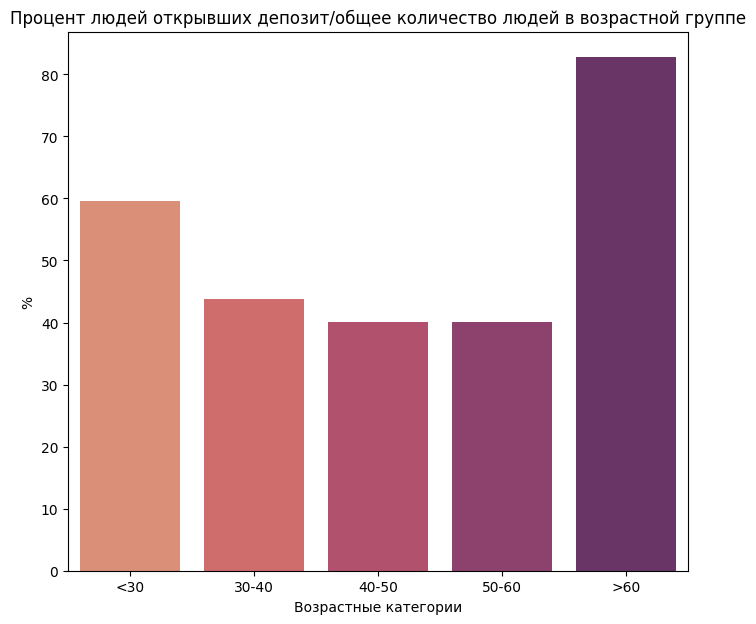

In [19]:
names = list(age.keys())
values = list(age.values())
plt.figure(figsize=(8,7))
fig = sns.barplot(x=names,y=values,palette='flare');
fig.set_title('Процент людей открывших депозит/общее количество людей в возрастной группе')
fig.set_xlabel('Возрастные категории')
fig.set_ylabel('%');



---
Как мы видим больше всего склонны принимать предложения люди до 30 лет, а также старше 60.
Если посмотреть на распределение признака возраста это самые малочисленные группы. Самые большие по численности возрастные группы реже принимают предложение банка 


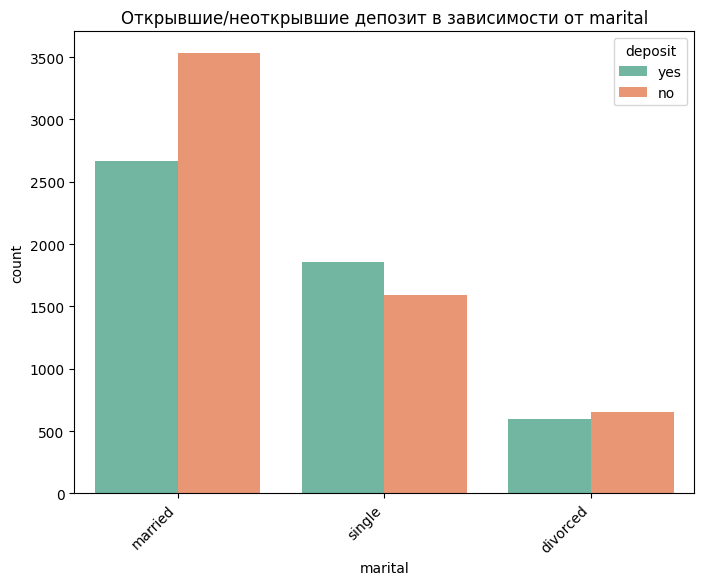

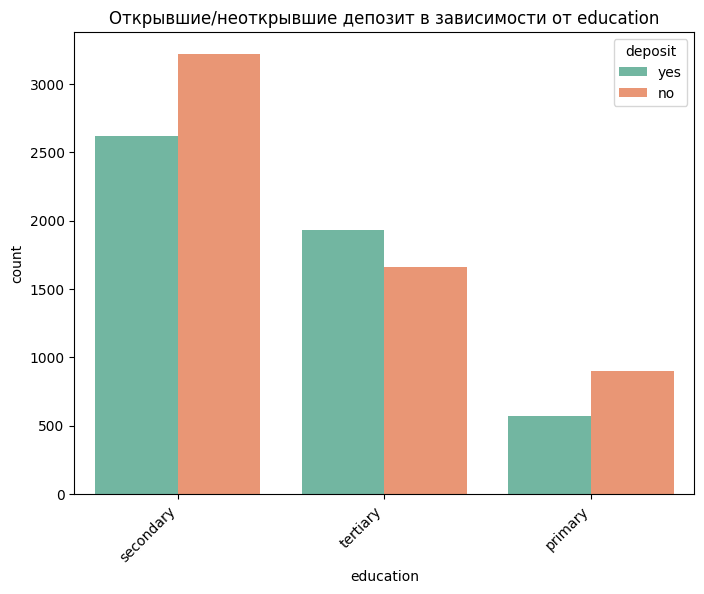

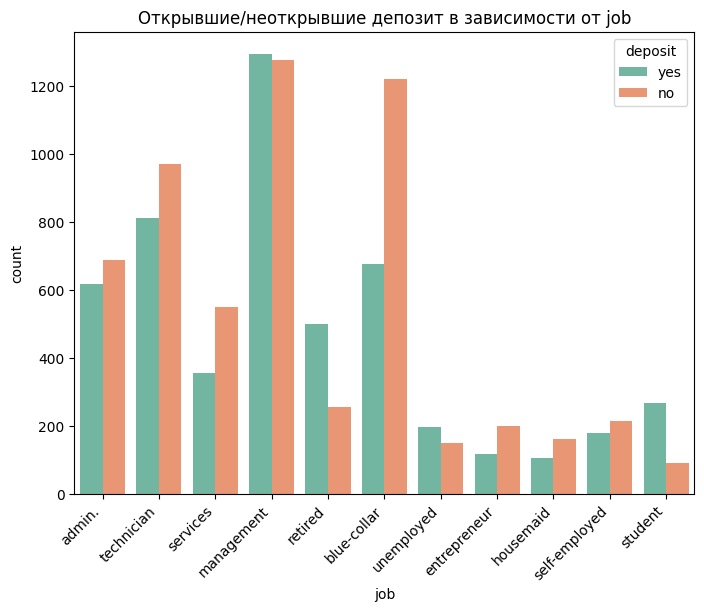

In [20]:
#  взглянем на численность групп людей открывших/неоткрывших депозит
# в зивисимости от семейного статуса, образования и сферы деятельности

columns_for_visual = ['marital','education','job']
for feature in columns_for_visual:
  plt.subplots(figsize=(8,6))
  fig = sns.countplot(x=df[feature],hue=df['deposit'],palette='Set2')
  fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
  fig.set_title(f'Открывшие/неоткрывшие депозит в зависимости от {feature}')



---
Из графиков видно:


*   Клиенты без пары более склонны открывать депозит из всех групп, однако самая многочисленная группа(те кто женат/замужем) склонна отказываться от предложения банка
*   люди с высшим образованием чаще соглашаются на предложение, однако самая крупная группа людей со средним образованием чаще отказывается чем соглашается на открытие депозита
*  чаще всех принимают предложения студенты, и люди работающие занимающие управляющие должности(это видно из возрастных групп, которые чаще других принимают предложение). Самое большое количество отказов в зависимости от принятия предложения у группы людей заминающихся физическим трудом.






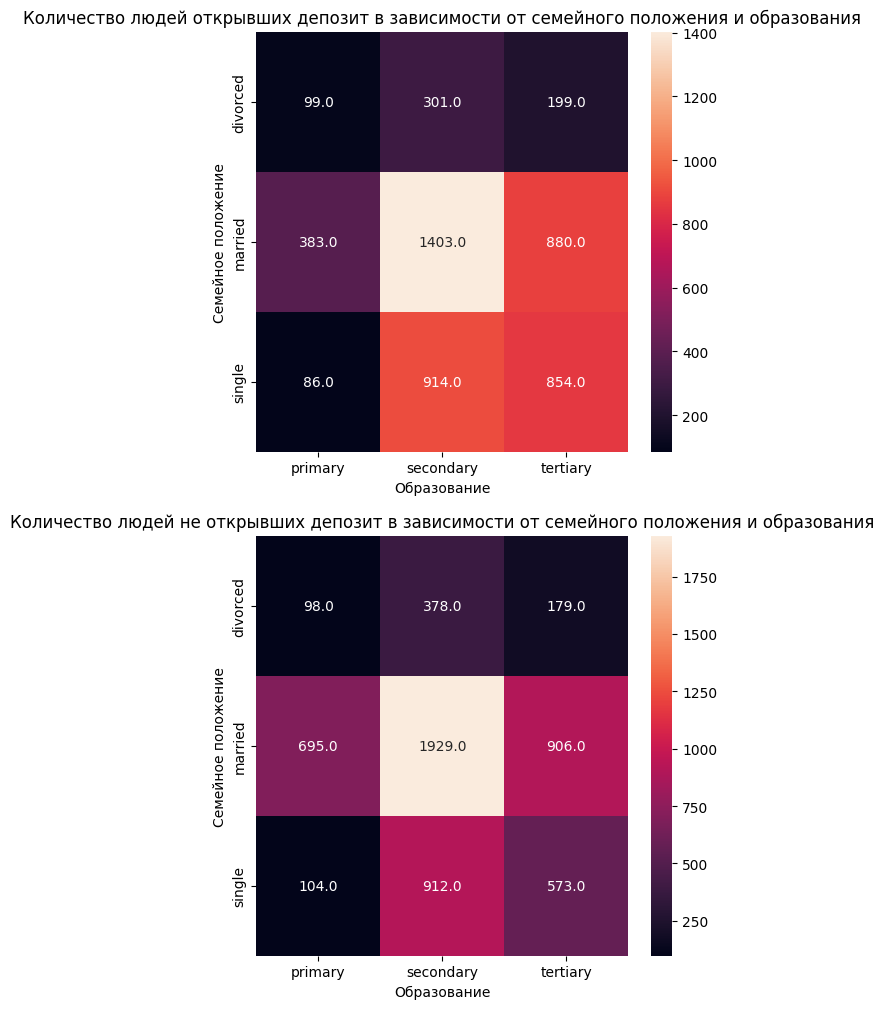

In [21]:
# Построим тепловую карту для групп людей в зависимости от образвания и 
# семейного положения, которые приняли и отказались от предложения банка

# разобьем выборку на группы:
grouped_1 = df[df['deposit'] =='yes'][['deposit','education','marital']]
grouped_2 = df[df['deposit'] =='no'][['deposit','education','marital']]
# создадим сводные таблицы из групп
pivot_1 = pd.pivot_table(grouped_1,values='deposit',index='marital',columns='education',aggfunc='count')
pivot_2 = pd.pivot_table(grouped_2,values='deposit',index='marital',columns='education',aggfunc='count')
# построим тепловые карты
fig,axes = plt.subplots(2,1,figsize=(6,12))
sns.heatmap(pivot_1,ax=axes[0],annot=True,fmt='.1f');
axes[0].set_title('Количество людей открывших депозит в зависимости от семейного положения и образования')
axes[0].set_xlabel('Образование')
axes[0].set_ylabel('Семейное положение')
sns.heatmap(pivot_2,ax=axes[1],annot=True,fmt='.1f');
axes[1].set_title('Количество людей не открывших депозит в зависимости от семейного положения и образования')
axes[1].set_xlabel('Образование')
axes[1].set_ylabel('Семейное положение');

Из изображений видно: 
больше всех открывают депозит и отказываются люди женатые/за мужем со средним образованием. (самая большая группа из распределения)
На втором месте по согласию и отказу одинокие люди со среднем образованием.

## Часть 3: Преобразование данных

In [22]:
# Закодируем признаки порядковым кодированием
columns_for_transform = ['education','default','housing','loan','deposit']
le = LabelEncoder()
for feature in columns_for_transform:
  df[feature] = le.fit_transform(df[feature])


In [23]:
# преобразуем признак возраста на возрастные группы, которые ранее рассматривали
def age_category(digit):
  if digit < 30:
    return 0
  elif digit in range(30,40):
    return 1
  elif digit in range(40,50):
    return 2
  elif digit in range(50,60):
    return 3
  elif digit >= 60: 
    return 4
# применим функцию к столбцу
df['age'] = df['age'].apply(age_category)

In [24]:
# остальные категориальные признаки закодируем onehot кодированием
df = pd.get_dummies(df)

Построим корреляционную матрицу, и посмотрим на наличие мультикорреляции среди признаков

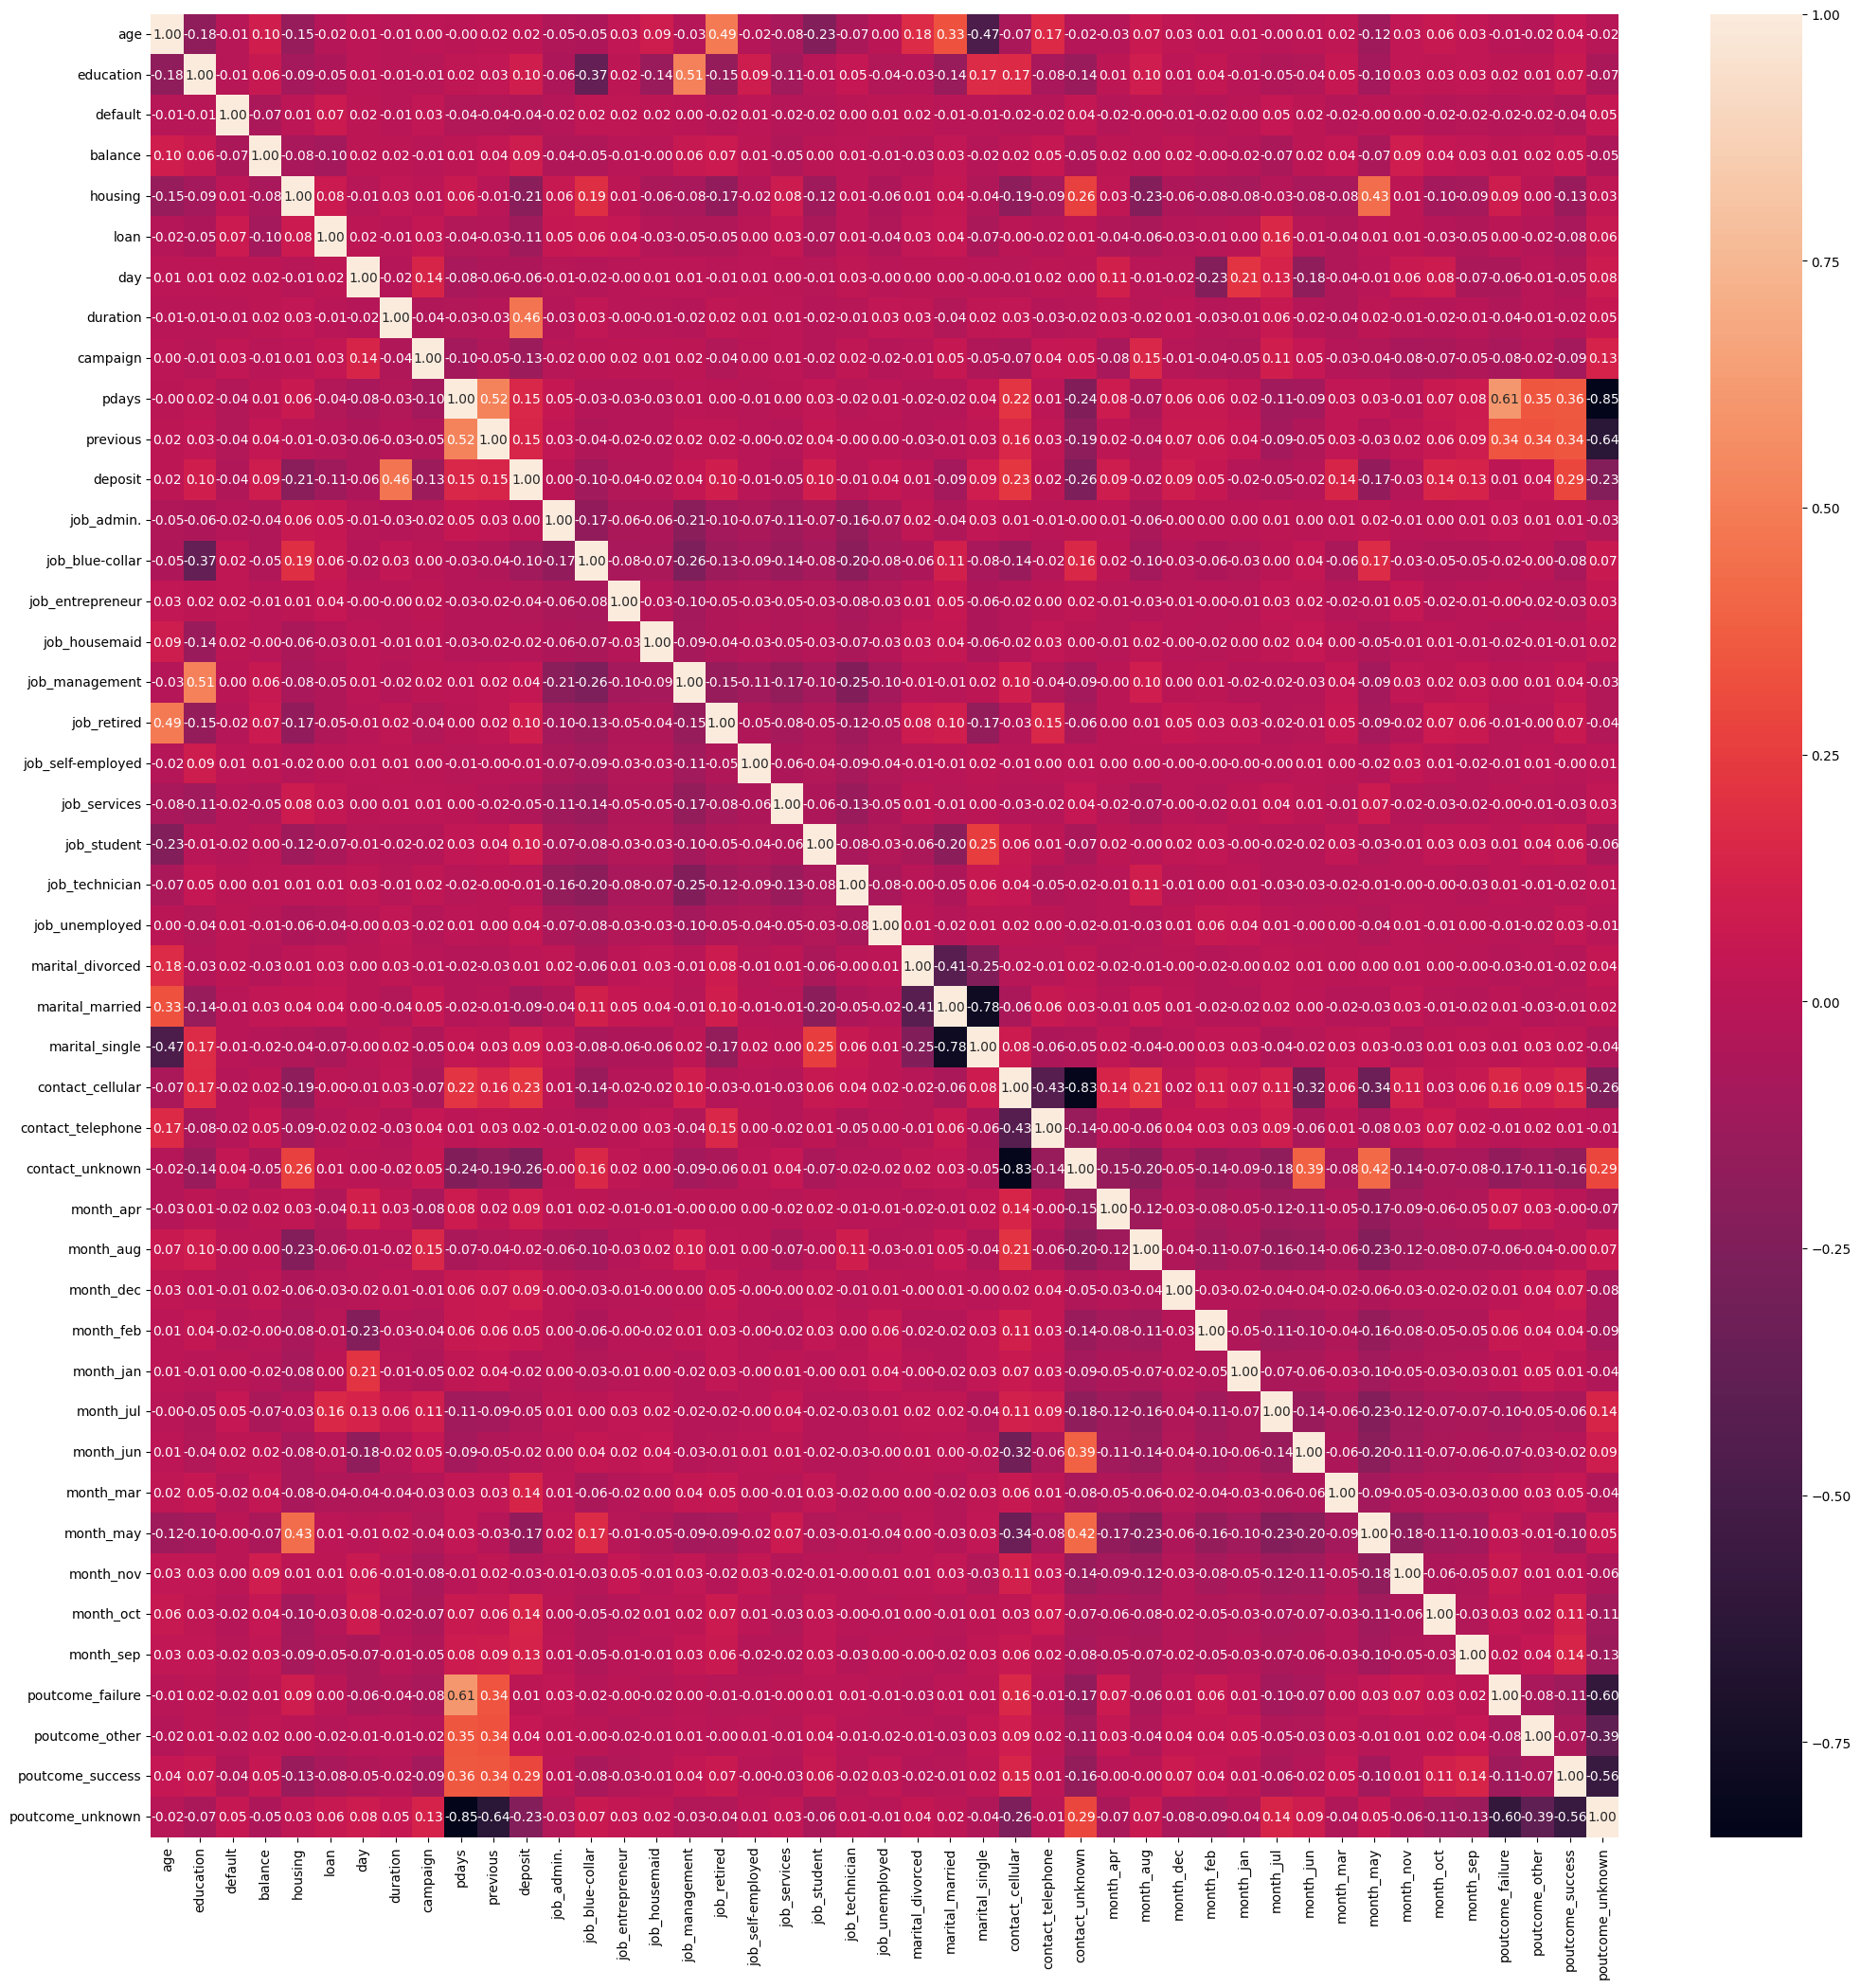

In [25]:
plt.figure(figsize=(25,25))
sns.heatmap(df.corr(),annot=True,fmt='.2f');



---
Построим столбчатую диаграмму, показывающую корреляцию признаков с целевой переменной

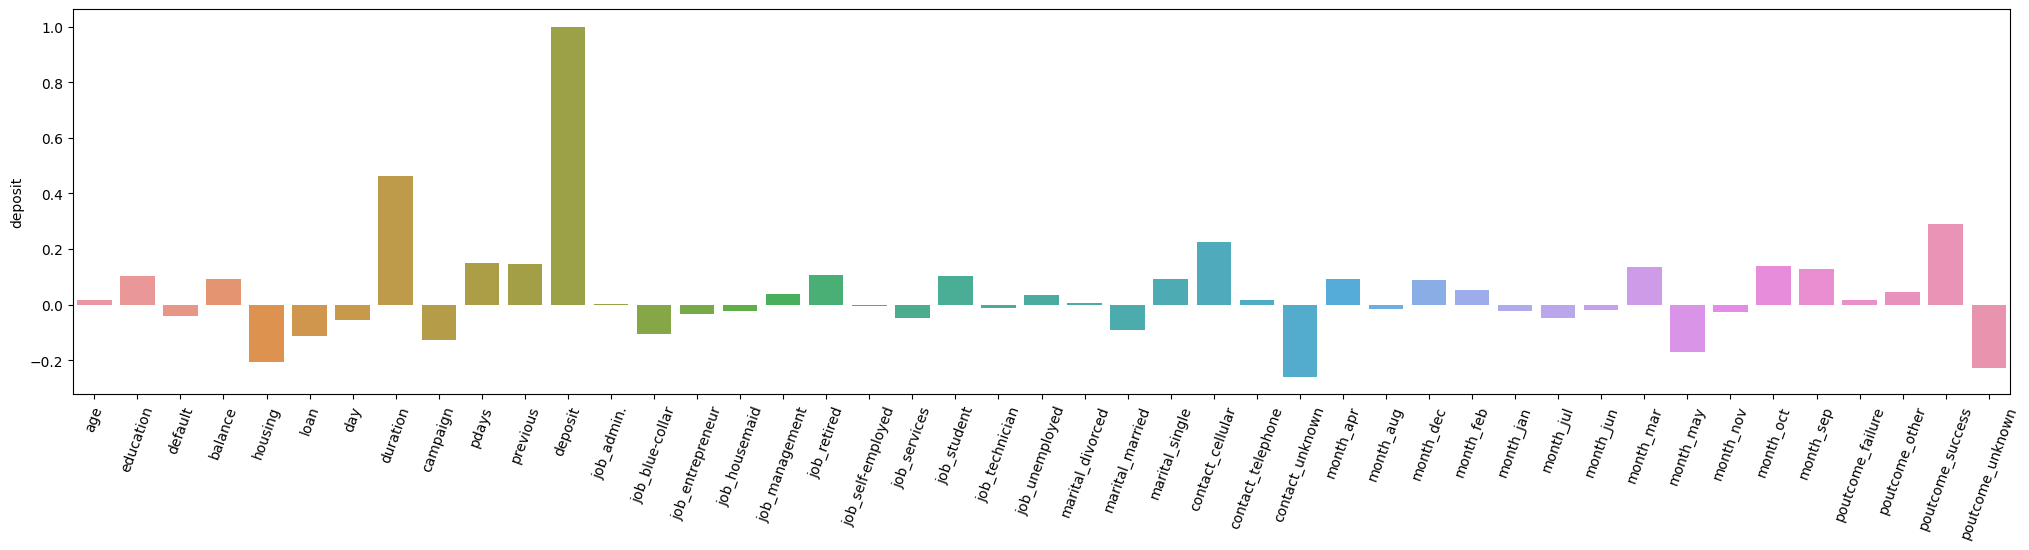

In [26]:
corr = df.corr()
plt.figure(figsize=(25,5))
fig = sns.barplot(x=corr.columns,
                  y=corr['deposit']
                  )
plt.xticks(rotation=70);

### Разделение выборки на тренировочную и тестовую

In [27]:
# Разобьем датасет на тренировочную и тестовую выборки
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42,test_size=0.33)

In [28]:
# Размеры выборок
print('Размер обучающей выборки: {}'.format(X_train.shape))
print('Размер тестовой выборки: {}'.format(X_test.shape))

Размер обучающей выборки: (7298, 44)
Размер тестовой выборки: (3595, 44)


In [29]:
# нормализуем данные с помощью minmaxsсaler
scaler = preprocessing.MinMaxScaler()
X_train_scaled,X_test_scaled = scaler.fit_transform(X_train),scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

In [30]:
# обучим логистическую регрессию и подберем оптимальные гиперпараметры с помощью optuna
def func(trials):
  model_log = linear_model.LogisticRegression(
      penalty=trials.suggest_categorical('penalty',['l2','l1','none']),
      solver='saga',
      n_jobs=-1,
      max_iter=1000,
      random_state=42,
      C=trials.suggest_int('C',low=1,high=6),
      class_weight='balanced' 
  )
  model_log.fit(X_train_scaled,y_train)
  return metrics.f1_score(y_train,model_log.predict(X_train_scaled))
 
study_lm_lg = optuna.create_study(direction='maximize',study_name='LogisticRegression')
study_lm_lg.optimize(n_trials=15,n_jobs=-1,func=func)

ml_lg = linear_model.LogisticRegression(**study_lm_lg.best_params,class_weight='balanced',random_state=42,n_jobs=-1,max_iter=1000,).fit(X_train_scaled,y_train)


[I 2022-12-23 09:54:45,864] A new study created in memory with name: LogisticRegression
[I 2022-12-23 09:54:46,130] Trial 3 finished with value: 0.8197393469029141 and parameters: {'penalty': 'none', 'C': 1}. Best is trial 3 with value: 0.8197393469029141.
[I 2022-12-23 09:54:46,238] Trial 2 finished with value: 0.8192206270143568 and parameters: {'penalty': 'l1', 'C': 2}. Best is trial 3 with value: 0.8197393469029141.
[I 2022-12-23 09:54:46,363] Trial 0 finished with value: 0.8187820983125458 and parameters: {'penalty': 'l2', 'C': 3}. Best is trial 3 with value: 0.8197393469029141.
[I 2022-12-23 09:54:46,399] Trial 1 finished with value: 0.8192206270143568 and parameters: {'penalty': 'l1', 'C': 4}. Best is trial 3 with value: 0.8197393469029141.
[I 2022-12-23 09:54:46,647] Trial 4 finished with value: 0.8192206270143568 and parameters: {'penalty': 'l1', 'C': 2}. Best is trial 3 with value: 0.8197393469029141.
[I 2022-12-23 09:54:46,890] Trial 7 finished with value: 0.8192206270143568

In [31]:
# Выведем результаты оптимизации и метрики качества
print("Наилучшие значения гиперпараметров {}".format(study_lm_lg.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_lm_lg.best_value))
print(metrics.classification_report(y_test,ml_lg.predict(X_test_scaled)))

Наилучшие значения гиперпараметров {'penalty': 'none', 'C': 1}
f1_score на обучающем наборе: 0.82
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1906
           1       0.82      0.82      0.82      1689

    accuracy                           0.83      3595
   macro avg       0.83      0.83      0.83      3595
weighted avg       0.83      0.83      0.83      3595



In [35]:
# обучим дерево решений, и подберем гиперпараметры
def func(trials):
  model_tree = tree.DecisionTreeClassifier(
      criterion=trials.suggest_categorical('criterion',['gini','entropy']),
      random_state=42,
      max_depth=trials.suggest_int('max_depth',2,10,1),
      min_samples_split=trials.suggest_int('min_samples_split',2,10,1),
      min_samples_leaf=trials.suggest_int('min_samples_leaf',3,10,1),
      class_weight='balanced'
      )
  model_tree.fit(X_train_scaled,y_train)
  tree_pred = model_tree.predict(X_train_scaled) 
  return metrics.f1_score(y_train,tree_pred)

tree_study = optuna.create_study(direction='maximize',study_name='DecisionTreeClassifier')
tree_study.optimize(n_trials=20,n_jobs=-1,func=func) 

model_tree = tree.DecisionTreeClassifier(**tree_study.best_params, class_weight='balanced', random_state=42).fit(X_train_scaled,y_train)

[I 2022-12-23 09:55:53,548] A new study created in memory with name: DecisionTreeClassifier
[I 2022-12-23 09:55:53,639] Trial 1 finished with value: 0.8129517201503325 and parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.8129517201503325.
[I 2022-12-23 09:55:53,667] Trial 0 finished with value: 0.846693657219973 and parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.846693657219973.
[I 2022-12-23 09:55:53,676] Trial 3 finished with value: 0.7950554853209721 and parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.846693657219973.
[I 2022-12-23 09:55:53,678] Trial 2 finished with value: 0.8504566210045663 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8504566210045663

In [36]:
print("Наилучшие значения гиперпараметров {}".format(tree_study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(tree_study.best_value))
print(metrics.classification_report(y_test,model_tree.predict(X_test_scaled)))

Наилучшие значения гиперпараметров {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 5}
f1_score на обучающем наборе: 0.86
              precision    recall  f1-score   support

           0       0.86      0.78      0.81      1906
           1       0.77      0.85      0.81      1689

    accuracy                           0.81      3595
   macro avg       0.81      0.81      0.81      3595
weighted avg       0.82      0.81      0.81      3595



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

In [37]:
# обучим на наших данных случайный лес
def func(trials):
  model_forest = ensemble.RandomForestClassifier(
      n_estimators=trials.suggest_int('n_estimators',300,350,1),
      criterion=trials.suggest_categorical('criterion',['gini','entropy']),
      min_samples_leaf=trials.suggest_int('min_samples_leaf',3,10,1),
      max_depth=trials.suggest_int('max_depth',2,8,1),
      random_state=42,
      class_weight=trials.suggest_categorical('class_weight',['balanced','balanced_subsample']),
      n_jobs=-1
  )
  model_forest.fit(X_train_scaled,y_train)
  return metrics.f1_score(y_train,model_forest.predict(X_train_scaled))

# подберем гиперпараметры 
forest_study = optuna.create_study(direction='maximize',study_name='RandomForestClassifier')
%time forest_study.optimize(n_trials=20,n_jobs=-1,func=func) 

model_forest = ensemble.RandomForestClassifier(**forest_study.best_params, random_state=42,n_jobs=-1).fit(X_train_scaled,y_train)


[I 2022-12-23 09:56:27,305] A new study created in memory with name: RandomForestClassifier
[I 2022-12-23 09:56:31,529] Trial 0 finished with value: 0.7696319907273255 and parameters: {'n_estimators': 303, 'criterion': 'entropy', 'min_samples_leaf': 4, 'max_depth': 2, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7696319907273255.
[I 2022-12-23 09:56:33,326] Trial 1 finished with value: 0.7639796659404503 and parameters: {'n_estimators': 301, 'criterion': 'gini', 'min_samples_leaf': 9, 'max_depth': 2, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.7696319907273255.
[I 2022-12-23 09:56:35,014] Trial 3 finished with value: 0.7954643318501508 and parameters: {'n_estimators': 345, 'criterion': 'entropy', 'min_samples_leaf': 7, 'max_depth': 4, 'class_weight': 'balanced_subsample'}. Best is trial 3 with value: 0.7954643318501508.
[I 2022-12-23 09:56:35,495] Trial 2 finished with value: 0.8278275475923852 and parameters: {'n_estimators': 347, 'criterion': 'g

CPU times: user 54.6 s, sys: 10.7 s, total: 1min 5s
Wall time: 35.2 s


In [38]:
print("Наилучшие значения гиперпараметров {}".format(forest_study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(forest_study.best_value))
print(metrics.classification_report(y_test,model_forest.predict(X_test_scaled)))

Наилучшие значения гиперпараметров {'n_estimators': 333, 'criterion': 'entropy', 'min_samples_leaf': 3, 'max_depth': 8, 'class_weight': 'balanced_subsample'}
f1_score на обучающем наборе: 0.86
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1906
           1       0.80      0.89      0.84      1689

    accuracy                           0.84      3595
   macro avg       0.85      0.85      0.84      3595
weighted avg       0.85      0.84      0.84      3595



In [39]:
# используем для классификации градиентный бустинг, подберем оптимальные параметры
def func(trials):
  ensemble_boosting = ensemble.GradientBoostingClassifier(
      # loss= trials.suggest_categorical('loss',['deviance', 'exponential']),
      learning_rate=trials.suggest_float('learning_rate',low=0.01,high=0.07,step=0.001),
      n_estimators=trials.suggest_int('n_estimators',200,250,1),
      min_samples_leaf=trials.suggest_int('min_samples_leaf',3,10,1),
      max_depth=trials.suggest_int('max_depth',2,5,1),
      criterion = trials.suggest_categorical('criterion',['friedman_mse', 'squared_error']),
      random_state=42
      )
  ensemble_boosting.fit(X_train_scaled,y_train)
  return metrics.f1_score(y_train,ensemble_boosting.predict(X_train_scaled))

boost_study = optuna.create_study(direction='maximize',study_name='GradientBoostingClassifier')
%time boost_study.optimize(n_trials=20,func=func,n_jobs=-1)
# обучим модель на подобранных параметрах
ensemble_boosting = ensemble.GradientBoostingClassifier(**boost_study.best_params,random_state=42).fit(X_train_scaled,y_train)


[I 2022-12-23 09:57:32,518] A new study created in memory with name: GradientBoostingClassifier
[I 2022-12-23 09:57:39,406] Trial 1 finished with value: 0.8752654679314739 and parameters: {'learning_rate': 0.059000000000000004, 'n_estimators': 203, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.8752654679314739.
[I 2022-12-23 09:57:39,521] Trial 0 finished with value: 0.8721144313836567 and parameters: {'learning_rate': 0.05, 'n_estimators': 202, 'min_samples_leaf': 4, 'max_depth': 4, 'criterion': 'squared_error'}. Best is trial 1 with value: 0.8752654679314739.
[I 2022-12-23 09:57:39,648] Trial 3 finished with value: 0.8367552045944007 and parameters: {'learning_rate': 0.013000000000000001, 'n_estimators': 220, 'min_samples_leaf': 6, 'max_depth': 4, 'criterion': 'friedman_mse'}. Best is trial 1 with value: 0.8752654679314739.
[I 2022-12-23 09:57:40,821] Trial 2 finished with value: 0.8634298693923907 and parameters: {'learning_rate':

CPU times: user 1min 20s, sys: 736 ms, total: 1min 20s
Wall time: 28.5 s


In [40]:
print("Наилучшие значения гиперпараметров {}".format(boost_study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(boost_study.best_value))
print(metrics.classification_report(y_test,ensemble_boosting.predict(X_test_scaled)))

Наилучшие значения гиперпараметров {'learning_rate': 0.041, 'n_estimators': 235, 'min_samples_leaf': 5, 'max_depth': 5, 'criterion': 'friedman_mse'}
f1_score на обучающем наборе: 0.89
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1906
           1       0.83      0.88      0.86      1689

    accuracy                           0.86      3595
   macro avg       0.86      0.86      0.86      3595
weighted avg       0.86      0.86      0.86      3595



In [41]:
# посмотрим какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
values = ensemble_boosting.feature_importances_
labels = X_train.columns
pd.DataFrame(data=values,index=labels,columns=['importance']).sort_values(by='importance',ascending=False)[:7:]

,importance
duration,0.444671
poutcome_success,0.109592
contact_unknown,0.082879
housing,0.049903
balance,0.035813
pdays,0.035085
day,0.034107


In [43]:
# попробуем использовать ансамбль из моделей, которые до этого обучали и посмотрим итоговый результат
def func(trials):
  # Базовыми моделями будут случайный лес, логистическая регрессия и градиентный бустинг
  estimators = [
    ('rf',ensemble.RandomForestClassifier(**forest_study.best_params,random_state=42,n_jobs=-1)),
    ('gb',ensemble.GradientBoostingClassifier(**boost_study.best_params,random_state=42)),
    ('tr',tree.DecisionTreeClassifier(**tree_study.best_params,class_weight='balanced',random_state=42))
  ]
  # финальной моделью будет логистическая регрессия
  final_estimator = linear_model.LogisticRegression(
      penalty=trials.suggest_categorical('penalty',['l2','l1','none']),
      solver='saga',
      n_jobs=-1,
      max_iter=1000,
      random_state=42,
      C=trials.suggest_int('C',low=1,high=6),
      class_weight='balanced' 
  )
  
  model_stack = ensemble.StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    cv=StratifiedKFold(5))
  
  model_stack.fit(X_train_scaled,y_train)
  return metrics.f1_score(y_train,model_stack.predict(X_train_scaled))

stack_study = optuna.create_study(direction='maximize',study_name='StackingClassifier')
%time stack_study.optimize(n_trials=15,func=func,n_jobs=-1)

[I 2022-12-23 10:01:12,535] A new study created in memory with name: StackingClassifier
[I 2022-12-23 10:01:50,517] Trial 0 finished with value: 0.8852643419572555 and parameters: {'penalty': 'l1', 'C': 4}. Best is trial 0 with value: 0.8852643419572555.
[I 2022-12-23 10:01:57,248] Trial 3 finished with value: 0.884793923195949 and parameters: {'penalty': 'l2', 'C': 1}. Best is trial 0 with value: 0.8852643419572555.
[I 2022-12-23 10:02:08,485] Trial 2 finished with value: 0.8855133614627286 and parameters: {'penalty': 'l2', 'C': 5}. Best is trial 2 with value: 0.8855133614627286.
[I 2022-12-23 10:02:19,320] Trial 1 finished with value: 0.8855133614627286 and parameters: {'penalty': 'l2', 'C': 6}. Best is trial 2 with value: 0.8855133614627286.
[I 2022-12-23 10:02:42,013] Trial 4 finished with value: 0.8852320675105485 and parameters: {'penalty': 'l2', 'C': 3}. Best is trial 2 with value: 0.8855133614627286.
[I 2022-12-23 10:02:44,904] Trial 5 finished with value: 0.8857625211029825 an

CPU times: user 8.39 s, sys: 1.37 s, total: 9.76 s
Wall time: 3min 31s


In [48]:
# обучим модель с полученными параметрами 
estimators = [
   ('rf',ensemble.RandomForestClassifier(**forest_study.best_params,random_state=42,n_jobs=-1)),
    ('gb',ensemble.GradientBoostingClassifier(**boost_study.best_params,random_state=42)),
    ('tr',tree.DecisionTreeClassifier(**tree_study.best_params,class_weight='balanced',random_state=42))
    ]
final_estimator = linear_model.LogisticRegression(**stack_study.best_params,
                        random_state=42,max_iter=1000,n_jobs=-1,solver='saga',class_weight='balanced')

ensemble_stack = ensemble.StackingClassifier( estimators=estimators,
                                             final_estimator=final_estimator,
                                             n_jobs=-1,
                                             cv=StratifiedKFold(5)).fit(X_train_scaled,y_train)      

In [49]:
print("Наилучшие значения гиперпараметров {}".format(stack_study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(stack_study.best_value))
print(metrics.classification_report(y_test,ensemble_stack.predict(X_test_scaled)))

Наилучшие значения гиперпараметров {'penalty': 'l1', 'C': 1}
f1_score на обучающем наборе: 0.89
              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1906
           1       0.83      0.88      0.85      1689

    accuracy                           0.86      3595
   macro avg       0.86      0.86      0.86      3595
weighted avg       0.86      0.86      0.86      3595



### Итоговые результаты

In [50]:
print('Результат LogisticRegression:', '\n', metrics.classification_report(y_test,ml_lg.predict(X_test_scaled)))
print('--------------------------------------------------------')
print('Результат DecisionTreeClassifier:', '\n', metrics.classification_report(y_test,model_tree.predict(X_test_scaled)))
print('--------------------------------------------------------')
print('Результат RandomForestClassifier:', '\n', metrics.classification_report(y_test,model_forest.predict(X_test_scaled)))
print('--------------------------------------------------------')
print('Результат GradientBoostingClassifier:','\n', metrics.classification_report(y_test,ensemble_boosting.predict(X_test_scaled)))
print('--------------------------------------------------------')
print('Результат StackingClassifier:', '\n', metrics.classification_report(y_test,ensemble_stack.predict(X_test_scaled)))

Результат LogisticRegression: 
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1906
           1       0.82      0.82      0.82      1689

    accuracy                           0.83      3595
   macro avg       0.83      0.83      0.83      3595
weighted avg       0.83      0.83      0.83      3595

--------------------------------------------------------
Результат DecisionTreeClassifier: 
               precision    recall  f1-score   support

           0       0.86      0.78      0.81      1906
           1       0.77      0.85      0.81      1689

    accuracy                           0.81      3595
   macro avg       0.81      0.81      0.81      3595
weighted avg       0.82      0.81      0.81      3595

--------------------------------------------------------
Результат RandomForestClassifier: 
               precision    recall  f1-score   support

           0       0.89      0.81      0.85      1906
           1       